In [1]:
import os

In [2]:
print(os.listdir("./food-101 - Copy/images"))

['train', 'valid']


We are given the difficult task to classify images of food, where if given an image of a dish, the program would tell us what its best guess of what the dish might be.  We have a dataset of 101 different dishes (food categories) each with 1000 sample images of each dish.  Luckily the dataset is already split for us (in the meta folder there are image files that are our test data and the image files that are our training data).   

Because all of our data is in the form of images, my first thought was to use a convolutional neural network (CNN).  This is because it allows us to skip the step of choosing features that may bias our results.  Also it allows us to avoid the task of labeling all these features on our data.  This also allows us to use the data of the whole image instead of relying on potentially arbitrary features that are human produced.

I decided to use the fastai library because it provides a nice, easy to use, framework to train a CNN.  Inorder to use this framework, the data had to be in a specific file tree format.  I wrote a small python script that moved these files to match this format.

I decided to go with resnet because, from the benchmarks (https://dawn.cs.stanford.edu/benchmark/) most of the top competitors were using the resnet model.

The stipulation was given to us that we had to use a resnet50 or smaller network.  Initially I started with a resnet34 CNN, but I quickly realized this was not going to yield the accuracy that I desired.  Even with tweaking, I was barely able to get above 70% accuracy.  This is the reason I eventually decided to use resnet50

Below is just some initialization.

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
path = './food-101 - Copy/images'

In [6]:
bs = 64

With my image data, I decided to do a few augmentations on my training data.  The get_transforms() function gets a number of augmentations including rotating, flipping horizontally, and zooming.  This makes intuitive sense because if for example, an image of a steak were rotated, flipped, or zoomed in on slightly, it would still be able to be recognized as a steak (the classification, "steak" should not be changed).  

I also normalized the color and contrast my image data so that they would have the same average and standard deviation as the imagenet images.  We use the stats of the imagenet images because we are using the trained weights from imagenet to avoid starting from random weights to hopefully lead to a faster convergence.  We want the same stats because essentially, we do not want the lighting to affect the classification.  (ie. a picture of a steak with bright lighting should not be classified any differently than a picture of a steak with dim lighting)

In [7]:
data=ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs, num_workers=0).normalize(imagenet_stats)

After setting up my data, I decided to check if this was indeed my data, so I printed out a few images along with their classes.  Also, I decided to print out all of the classes as well as the overall number of classes. After checking everything I was convinced that this was indeed my data.

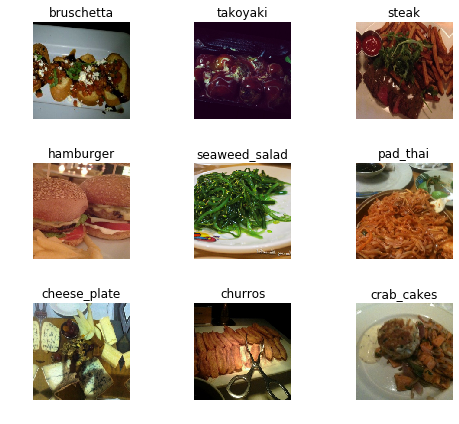

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
print(data.classes)
data.c

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

101

I then setup my CNN with the resnet50 model.

In [10]:
learn = create_cnn(data,models.resnet50, metrics=error_rate, path = '../working')

C:\Users\bbqwe\Anaconda3\lib\site-packages\fastai\vision\learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Learning rate is one of the most important hyperparameters in a CNN.  If we have too big of a learning rate, the program may never find a local minimum, and if we have too small of a learning rate, it may take too much time to reach a local minimum.  To find an optimial learning rate, we make a plot of the loss vs. the learning rate.  The part steepest decreasing part of this graph would be our ideal learning rate.  

In [11]:
learn.unfreeze()

In [12]:
learn.lr_find(start_lr=1e-11, end_lr=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


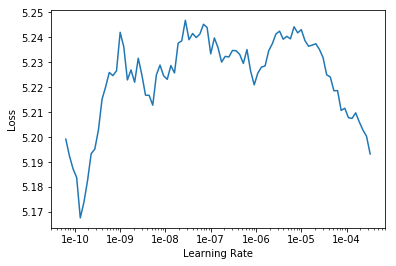

In [13]:
learn.recorder.plot()

From the above graph,I decided that the learning rate should be somewhere close to the rightmost peak.  I chose the rightmost peak because I don't want a learning rate that is too small, or else it would take too long to converge.   

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(10, max_lr=slice(3e-5, 6e-5))

epoch,train_loss,valid_loss,error_rate,time
0,3.911814,3.269913,0.694099,41:20
1,2.004021,1.357808,0.315723,40:19
2,1.372344,0.902790,0.232317,40:30
3,1.066966,0.737678,0.193782,40:44
4,0.906174,0.664825,0.179842,40:46
5,0.792127,0.611202,0.168277,41:06
6,0.682320,0.577452,0.156792,40:49
7,0.543768,0.556693,0.152911,40:40
8,0.476650,0.550635,0.150455,40:46
9,0.463843,0.550126,0.149901,40:54


In [16]:
learn.save('Model-3Slice')

With that, after 10 iterations we have achieved our goal of getting 85% (we got 85.0099%) accuracy on our validation data.  It is important that we measure accuracy on our validation data and not our training data because a model that predicts the training data correctly is prone to overfitting (where it only predicts the training data well, and not other cases).  That is why we measure our accuracy with our validation data, to assure the model can accurately predict cases it has not already seen before.  

We can now also see which cases in our validation data our model predicts incorrectly.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

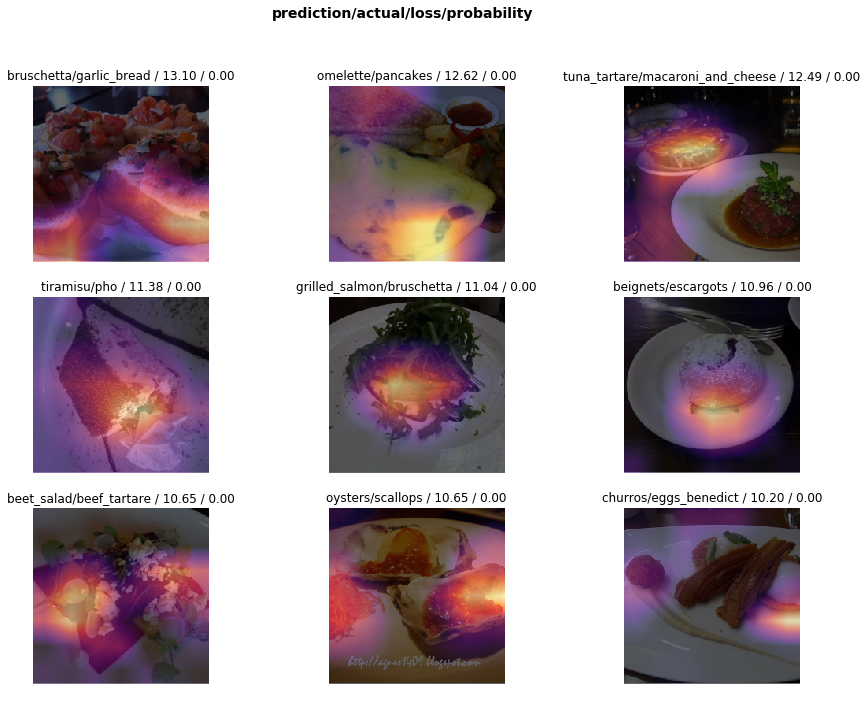

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

From this we actually see a couple of issues.  Firstly, many of these pictures have multiple dishes, so the program may classify the wrong dish in the picture.  Also, many of these "wrong" predictions are actually of mislabeled data.  I believe a lot of them classified the acutal picture correctly, but the picture was initially mislabeled so it was marked wrong.  This makes me confident that our program was trained correctly

We can also take a look at the confusion matrix to see what was most misclassified.

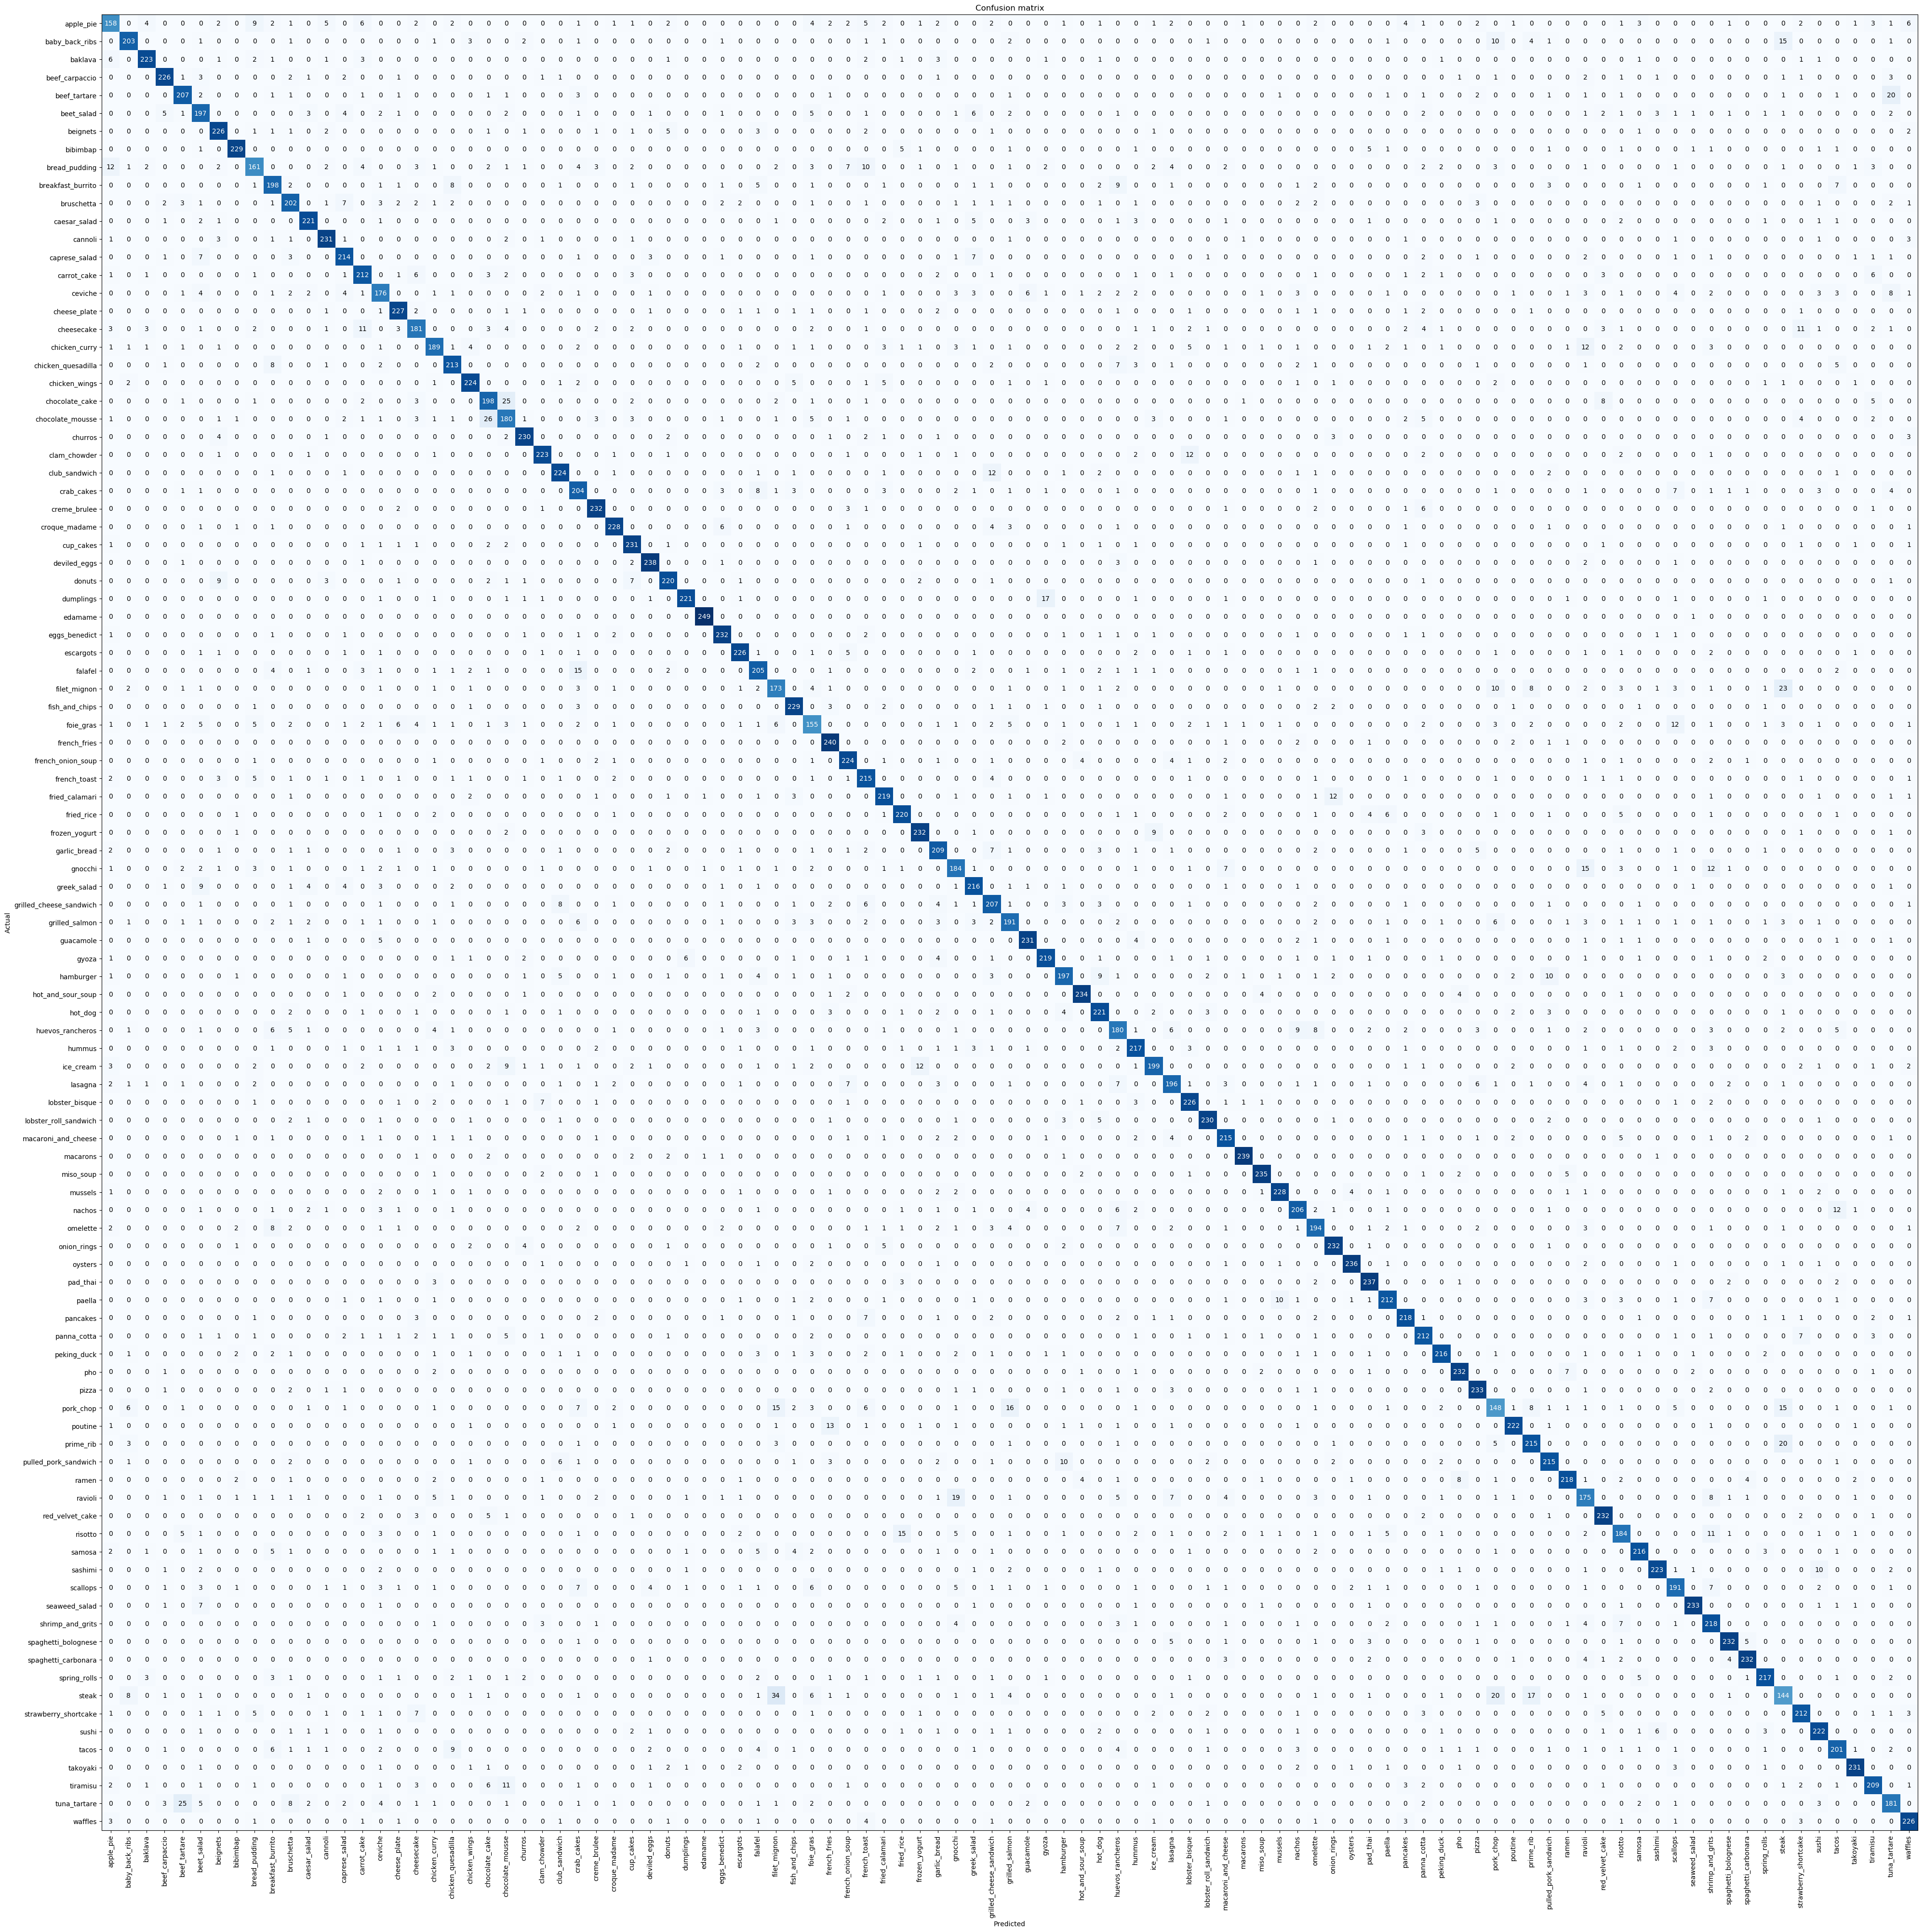

In [25]:
interp.plot_confusion_matrix(figsize=(40,40), dpi=100)

From the confusion matrix we can see mistakes that are understandable.  For example, tuna tartare and beef tartare are often mistaken as one another.  Also, filet_mignon and steak are often confused as one another.  (which is understandable because filet mignon is a type of steak)

We can also take a look at the most commonly mistakes the program makes in classification:

In [26]:
interp.most_confused(min_val=2)

[('steak', 'filet_mignon', 34),
 ('chocolate_mousse', 'chocolate_cake', 26),
 ('chocolate_cake', 'chocolate_mousse', 25),
 ('tuna_tartare', 'beef_tartare', 25),
 ('filet_mignon', 'steak', 23),
 ('beef_tartare', 'tuna_tartare', 20),
 ('prime_rib', 'steak', 20),
 ('steak', 'pork_chop', 20),
 ('ravioli', 'gnocchi', 19),
 ('dumplings', 'gyoza', 17),
 ('steak', 'prime_rib', 17),
 ('pork_chop', 'grilled_salmon', 16),
 ('baby_back_ribs', 'steak', 15),
 ('falafel', 'crab_cakes', 15),
 ('gnocchi', 'ravioli', 15),
 ('pork_chop', 'filet_mignon', 15),
 ('pork_chop', 'steak', 15),
 ('risotto', 'fried_rice', 15),
 ('poutine', 'french_fries', 13),
 ('bread_pudding', 'apple_pie', 12),
 ('chicken_curry', 'ravioli', 12),
 ('clam_chowder', 'lobster_bisque', 12),
 ('club_sandwich', 'grilled_cheese_sandwich', 12),
 ('foie_gras', 'scallops', 12),
 ('fried_calamari', 'onion_rings', 12),
 ('gnocchi', 'shrimp_and_grits', 12),
 ('ice_cream', 'frozen_yogurt', 12),
 ('nachos', 'tacos', 12),
 ('cheesecake', 'carro

We see that a lot of these are very commonly confused because of the same reasons as listed above.  A lot of the categories are a sub category of the other (for example poutine is a french fry dish).

We can also take a look at what data in the training data itself gets misclassified:

In [28]:
interp2 = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)

Again, we can now take a look at what pictures in our training is misclassified.

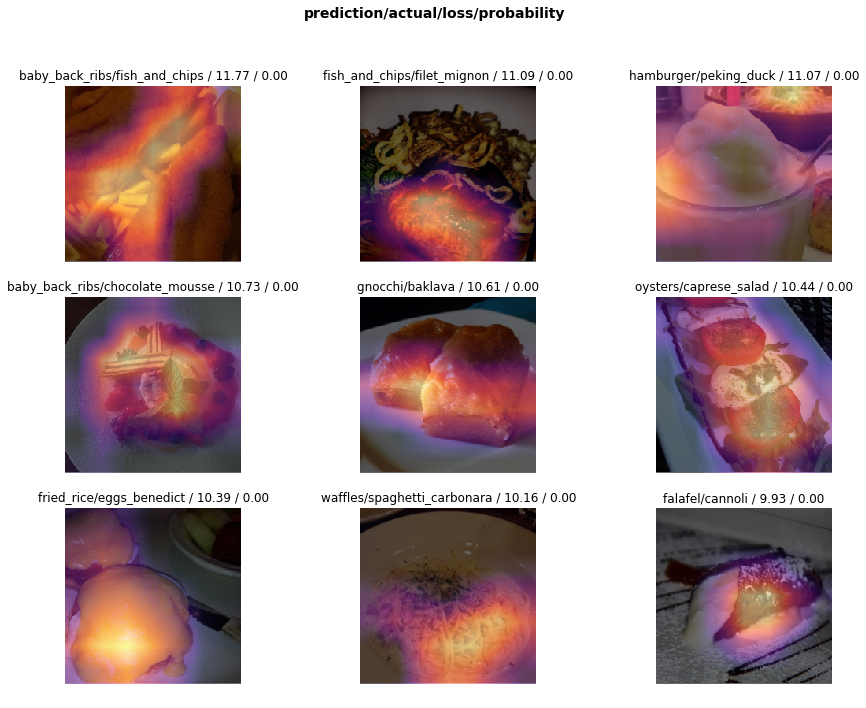

In [29]:
interp2.plot_top_losses(9, figsize=(15,11))

We can see that this time, contrary to the validation data, most things seem to be classified correctly (apart from the "peking duck" which may be a bad crop).

We can again also look at which classes were most mistaken for one another:

In [30]:
interp2.most_confused(min_val=2)

[('steak', 'filet_mignon', 95),
 ('filet_mignon', 'steak', 74),
 ('chocolate_mousse', 'chocolate_cake', 61),
 ('dumplings', 'gyoza', 49),
 ('chocolate_cake', 'chocolate_mousse', 42),
 ('bread_pudding', 'apple_pie', 40),
 ('steak', 'pork_chop', 38),
 ('beef_tartare', 'tuna_tartare', 34),
 ('prime_rib', 'steak', 33),
 ('apple_pie', 'bread_pudding', 30),
 ('gnocchi', 'ravioli', 30),
 ('steak', 'prime_rib', 29),
 ('pork_chop', 'steak', 28),
 ('ravioli', 'lasagna', 28),
 ('tuna_tartare', 'beef_tartare', 28),
 ('cheesecake', 'panna_cotta', 24),
 ('ice_cream', 'frozen_yogurt', 24),
 ('donuts', 'beignets', 22),
 ('onion_rings', 'fried_calamari', 22),
 ('ravioli', 'gnocchi', 22),
 ('frozen_yogurt', 'ice_cream', 20),
 ('prime_rib', 'pork_chop', 20),
 ('sashimi', 'sushi', 20),
 ('cheesecake', 'strawberry_shortcake', 19),
 ('tiramisu', 'chocolate_mousse', 19),
 ('filet_mignon', 'pork_chop', 18),
 ('grilled_cheese_sandwich', 'club_sandwich', 18),
 ('ceviche', 'tuna_tartare', 17),
 ('fried_calamari'

These results are again expected.  Many of these foods look a lot like one another (for example onion rings and fried calamari) or are a subclass of one another (for example gyoza are a type of dumpling).

**Future work/Improvements:**

To get more accurate results, we can perhaps check which categories are redundant.  For example, to have both steak and filet mignon is redundant.  We can either keep steak and consolidate all steak pictures into one category, or we can separate all different types of steaks. 

Another thing we can do to improve results is remove all the obviously misclassified misclassified data.  (This can be found easily with the plot_top_losses function).

In the future we can also add more categories of foods to this classification.  Eventually, the goal would be to develop a program that can identify any food from a picture.